In [6]:
import numpy as np
from pyeeg import TRFEstimator
import matplotlib.pyplot as plt
from scipy.signal import convolve, filtfilt, butter

# Matplotlib
dark_mode = True
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 12
if dark_mode:
    plt.rcParams['axes.facecolor'] = '#1e1e1e'
    plt.rcParams['axes.edgecolor'] = '#ffffff'
    plt.rcParams['axes.labelcolor'] = '#ffffff'
    plt.rcParams['xtick.color'] = '#ffffff'
    plt.rcParams['ytick.color'] = '#ffffff'
    plt.rcParams['figure.facecolor'] = '#1e1e1e'
    plt.rcParams['figure.edgecolor'] = '#1e1e1e'

In [ ]:
# Parameters
fs = 100  # Sampling frequency
duration = 30  # Duration in seconds
n_samples = int(fs * duration)  # Number of samples
tmin = -0.5
tmax = 0.5
t_kernel = np.arange(tmin, tmax, 1/fs)  # Time vector for kernel
n_events = 100  # Number of events

In [7]:
# Simulated data
# TRF kernel
peak_time = 0.2  # Time of the peak in seconds (seconds)
width = 0.05  # Width of the Gaussian kernel (seconds)
kernel = np.diff(np.r_[0.0, np.exp(-(t_kernel - peak_time)**2 / (2 * width**2))])  # Gaussian kernel derivative
# Stimuli (smooth continuous one + event based one)
smooth_stimulus = np.random.randn(n_samples,)  # Random stimulus
b, a = butter(4, 15, 'low', fs=fs)  # Low-pass filter (15 Hz)
smooth_stimulus = filtfilt(b, a, smooth_stimulus)  # Filtered stimulus
event_stimulus = np.zeros((n_samples,))  # Event-based stimulus
onsets = np.random.randint(0, n_samples - 1, size=n_events)  # Random event onsets
event_stimulus[onsets] = 1  # Set event onsets to 1
# Convolve stimuli with kernel
y_smooth = convolve(smooth_stimulus, kernel, mode='same')  # Convolve with smooth stimulus
y_event = convolve(event_stimulus, kernel, mode='same')  # Convolve with event stimulus
# Add noise
y = y_smooth + y_event + np.random.randn(n_samples) * 0.1  # Add noise to the signal

# Create TRF estimator
trf = TRFEstimator(tmin=tmin, tmax=tmax, srate=fs, alpha=1.0)
print(np.c_[smooth_stimulus, event_stimulus].shape, y.shape) # 2 features, 1 channel
trf.fit(np.c_[smooth_stimulus, event_stimulus], y[:, None])

INFO:pyeeg:Lagging matrix...
INFO:pyeeg:Computing coefficients..


(3000, 2) (3000,)


TRFEstimator(
                alpha=1.0,
                fit_intercept=True,
                srate=100,
                tmin=-0.50
                tmax=0.50,
                n_feats=2,
                n_chans=1,
                n_lags=100,
                features : None
            )

INFO:pyeeg:Lagging matrix...
INFO:pyeeg:Computing coefficients..
INFO:pyeeg:Lagging matrix...
INFO:pyeeg:Computing coefficients..


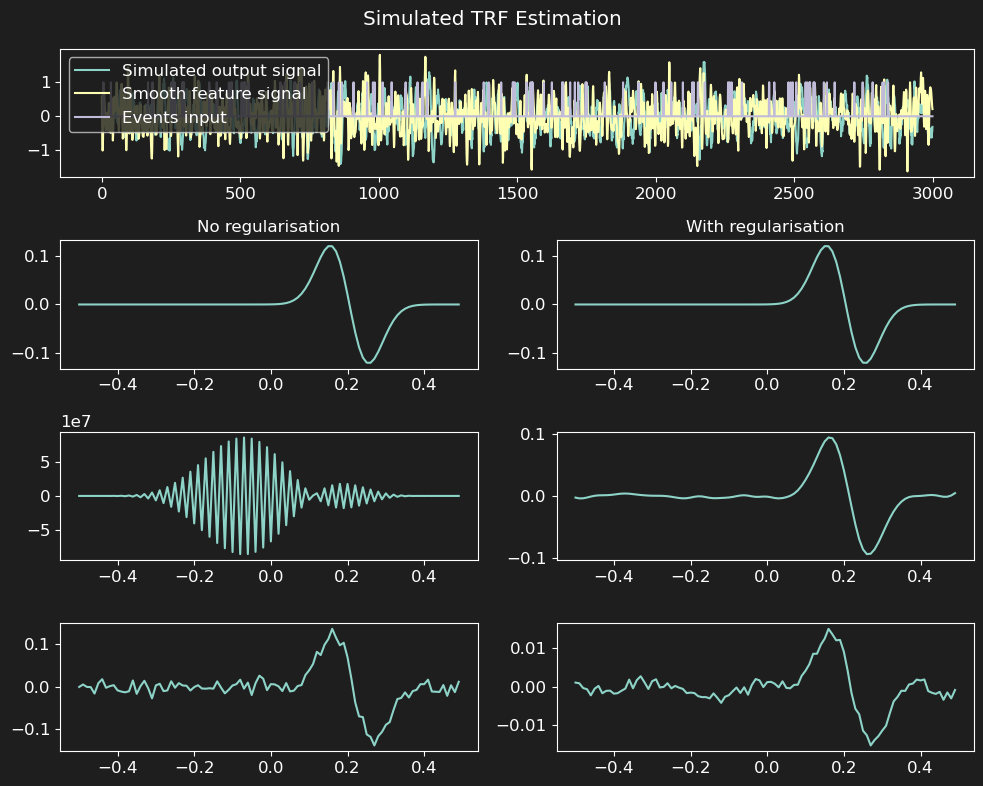

In [8]:
# Plot results
f, ax = plt.subplots(4, 2, figsize=(10, 8), sharey=False)
gs = ax[0, 0].get_gridspec()
for a in ax[0, :]: a.remove()
ax_wide = f.add_subplot(gs[0, :])
ax_wide.plot(y, label='Simulated output signal')
ax_wide.plot(smooth_stimulus, label='Smooth feature signal')
ax_wide.plot(event_stimulus, label='Events input')
ax_wide.legend()
# Plot estimated kernels and result
alphas = [0., 1e3]  # Regularisation parameters
for k, aax in enumerate(ax[1:, :].T):
    trf.alpha = alphas[k]  # Set regularisation parameter
    trf.fit(np.c_[smooth_stimulus, event_stimulus], y[:, None]) 
    aax[0].plot(t_kernel, kernel, label='Kernel')
    trf.plot(ax=aax[1:], show=False)
    if k==0:
        aax[0].set_title('No regularisation')
    else:
        aax[0].set_title('With regularisation')
f.suptitle('Simulated TRF Estimation')
f.tight_layout()